In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #解决运行时内核崩溃
import collections
import math
import os
import shutil
import pandas as pd
import torch 
import torchvision
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

**我们提供包含前1000个训练图像和5个随即测试图像的数据集的小规模样本**  
**cifar10_tiny是cifar10中每一个类把前面一千个训练图片拿出来，测试是每一个类挑五个图片**

In [2]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                               '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10'
print("data_dir: "+data_dir)

data_dir: ..\data\kaggle_cifar10_tiny


**整理数据集**

In [3]:
def read_csv_labels(fname):
    """读取 'fname' 来给标签字典返回一个文件名。"""
    with open(fname, 'r') as f:
        lines = f.readlines()[1:] # 一行一行读进来，每一行为列表中一个元素
    tokens = [l.rstrip().split(',') for l in lines] # 遍历列表每一个元素，切分
    return dict(((name, label) for name, label in tokens))
"""
一些语法：
1.关于f.readlines()[1:]
f.readlines()会返回一个列表，文件有多少行列表就有多少个元素，每个元素是对应的字符串，如果不是最后一行，字符串后面会加上'\n'
[1:]把第0行筛除了，返回了其余行

2.关于rstrip
lstrip和rstrip分别是去除字符串左边和右边的空格和制表符
strip是去除字符串左右两边的空格和制表符

3.列表推导式或生成器表达式
列表推导式:
y = [(name, label) for name, label in tokens]
等价于:
y = []
for name, label in tokens:
    y.append((name, label))

生成器表达式:
y = ((name, label) for name, label in tokens)
上面这个函数的return语句就是把一个生成器表达式转成了字典类型
"""
labels = read_csv_labels(os.path.join(data_dir,'trainLabels.csv'))
labels

{'1': 'frog',
 '2': 'truck',
 '3': 'truck',
 '4': 'deer',
 '5': 'automobile',
 '6': 'automobile',
 '7': 'bird',
 '8': 'horse',
 '9': 'ship',
 '10': 'cat',
 '11': 'deer',
 '12': 'horse',
 '13': 'horse',
 '14': 'bird',
 '15': 'truck',
 '16': 'truck',
 '17': 'truck',
 '18': 'cat',
 '19': 'bird',
 '20': 'frog',
 '21': 'deer',
 '22': 'cat',
 '23': 'frog',
 '24': 'frog',
 '25': 'bird',
 '26': 'frog',
 '27': 'cat',
 '28': 'dog',
 '29': 'deer',
 '30': 'airplane',
 '31': 'airplane',
 '32': 'truck',
 '33': 'automobile',
 '34': 'cat',
 '35': 'deer',
 '36': 'airplane',
 '37': 'cat',
 '38': 'horse',
 '39': 'cat',
 '40': 'cat',
 '41': 'dog',
 '42': 'bird',
 '43': 'bird',
 '44': 'horse',
 '45': 'automobile',
 '46': 'automobile',
 '47': 'automobile',
 '48': 'bird',
 '49': 'bird',
 '50': 'airplane',
 '51': 'truck',
 '52': 'dog',
 '53': 'horse',
 '54': 'truck',
 '55': 'bird',
 '56': 'bird',
 '57': 'dog',
 '58': 'bird',
 '59': 'deer',
 '60': 'cat',
 '61': 'automobile',
 '62': 'automobile',
 '63': 'ship',

**将验证集从原始的训练集中拆分出来**

In [4]:
'''
train文件夹下有所有train的图片，test文件夹下有所有test图片
把train文件夹下所有类的图片创建一个类名文件夹，然后搬到对应文件夹下
'''
def copyfile(filename, target_dir):
    """
    目标目录不存在就创建，存在就跳过
    将文件复制到目标目录
    """
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)
    
def reorg_train_valid(data_dir, labels, valid_ratio):
    '''
    data_dir是一个路径对应的字符串
    labels 是一个字典，key是文件名，value是label对应的字符串
    '''
    n = collections.Counter(labels.values()).most_common()[-1][1]
    '''
    labels.values()包含所有的value
    collections.Counter(labels.values())统计各个value出现的次数
    collections.Counter(labels.values())把统计结果按出现次数从多到少排成列表，列表元素是 (value, count) 的元组。
    [-1][1]，读取了最后一个元组中下标为1的元素，也就是最低的出现次数
    '''
    n_valid_per_label = max(1,math.floor(n * valid_ratio))
    '''最低出现的次数*验证数据的比例，得出用于验证的图片数目'''
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir,'train')):
        '''train_file是训练集中所有图片的文件名'''
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir,'train',train_file)
        '''
        label就是图片对应的label
        fname是当前遍历到的文件的绝对路径
        '''
        copyfile(fname,os.path.join(data_dir,'train_valid_test','train_valid',label))
        '''把所有训练数据copy到 "[data_dir]/train_valid_test/train_valid/" 目录下'''

        '''该label放进valid目录(验证集)的数量不足 n_valid_per_label 时，则放入验证集 否则放入训练集'''
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname,os.path.join(data_dir,'train_valid_test','valid',label))
            label_count[label] = label_count.get(label,0) + 1
        else:
            copyfile(fname,os.path.join(data_dir,'train_valid_test','train',label))
    return n_valid_per_label

**在预测期间整理测试集，以方便读取**

In [5]:
def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir,'test')):
        copyfile(os.path.join(data_dir,'test',test_file),
                os.path.join(data_dir,'train_valid_test','test','unknown')) # unknown为 test文件夹里面的一个文件夹
'''
到这里可以看出来四个目录都装的是什么东西了：
train_valid包含所有的训练数据（训练数据被分为了训练集和验证集）
valid包含是验证集对应的数据
train包含训练集对应的数据
test是测试集包含的数据
'''

'\n到这里可以看出来四个目录都装的是什么东西了：\ntrain_valid包含所有的训练数据（训练数据被分为了训练集和验证集）\nvalid包含是验证集对应的数据\ntrain包含训练集对应的数据\ntest是测试集包含的数据\n'

**调用前面定义的函数**

In [6]:
def reorg_cifar10_data(data_dir,valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir,'trainLabels.csv'))
    reorg_train_valid(data_dir,labels,valid_ratio)
    reorg_test(data_dir)
    
batch_size = 32 if demo else 128
'''train 数据里面百分之九十用来训练，剩下百分之十用来验证'''
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

**图像增广**

In [7]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32,scale=(0.64,1.0),ratio=(1.0,1.0)),#resize到40x40 再取面积的64%到100% 高宽比1:1，再resize到32x32
    torchvision.transforms.RandomHorizontalFlip(),#左右翻转
    torchvision.transforms.ToTensor(),#RGB值都类型转换为float32再除以255
    torchvision.transforms.Normalize([0.4914,0.4822,0.4465],
                                   [0.2023,0.1994,0.2010])])#修改RGB值的均值和方差(归一化)

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914,0.4822,0.4465],
                                    [0.2023,0.1994,0.2010]) ])


**读取由原始图像组成的数据集**

In [8]:
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir,'train_valid_test',folder)
        ,transform=transform_train) for folder in ['train','train_valid'] ]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir,'train_valid_test',folder),
        transform=transform_test) for folder in ['valid','test'] ]
'''
这一块的代码第一眼还没看懂
等号右边是列表推导式，得到一个列表，列表里的元素数量是2
逗号隔开两个变量放在等号左边直接就获取列表里的两个元素了(这个我刚刚试了试才知道)
python的语法真是神奇

接下来，torchvision.datasets.ImageFolder是干嘛的？
它从文件夹结构读取图像，并为每张图像分配标签（标签来自文件夹名）。
'''

'\n这一块的代码第一眼还没看懂\n等号右边是列表推导式，得到一个列表，列表里的元素数量是2\n逗号隔开两个变量放在等号左边直接就获取列表里的两个元素了(这个我刚刚试了试才知道)\npython的语法真是神奇\n\n接下来，torchvision.datasets.ImageFolder是干嘛的？\n它从文件夹结构读取图像，并为每张图像分配标签（标签来自文件夹名）。\n'

**查看通过`torchvision.datasets.ImageFolder`获得的数据**

数据集大小: 920
类别: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
类别数量: 10
类别索引: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
图像形状: torch.Size([3, 32, 32])
标签: 0
标签名称: airplane
像素值范围: [-2.216, 2.754]
文件名:..\data\kaggle_cifar10_tiny\train_valid_test\train\airplane\214.png


<function matplotlib.pyplot.show(close=None, block=None)>

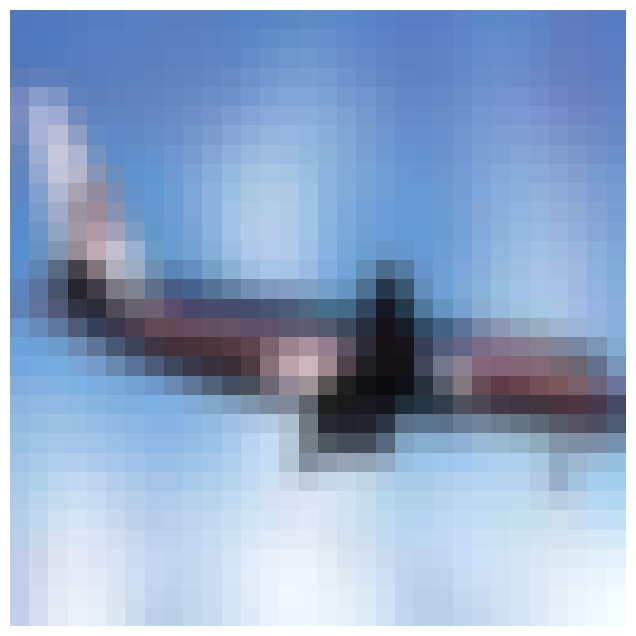

In [9]:
'''2.查看数据集基本信息'''
use_index = 0
# 查看数据集大小
print(f"数据集大小: {len(train_ds)}")

# 查看类别名称
print(f"类别: {train_ds.classes}")
print(f"类别数量: {len(train_ds.classes)}")

# 查看类别到索引的映射
print(f"类别索引: {train_ds.class_to_idx}")
'''2.查看单个样本'''
# 获取第一个样本
image, label = train_ds[use_index]

print(f"图像形状: {image.shape}")  # 例如: torch.Size([3, 224, 224])
print(f"标签: {label}")  # 整数索引
print(f"标签名称: {train_ds.classes[label]}")  # 对应的类别名

# 查看图像张量的值范围
print(f"像素值范围: [{image.min():.3f}, {image.max():.3f}]")
print(f"文件名:{train_ds.samples[use_index][0]}")
'''3.可视化图像'''
# 如果用了 Normalize，需要反归一化来显示
def denormalize(tensor, mean, std):
    """反归一化用于显示"""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# 获取一个样本
image, label = train_ds[use_index]
# 如果图像是归一化的，需要反归一化
image = denormalize(image.clone(), [0.4914,0.4822,0.4465], [0.2023,0.1994,0.2010])

# 转换为 numpy 并调整维度顺序 (C, H, W) -> (H, W, C)
image_np = image.permute(1, 2, 0).numpy()

# 显示图像
plt.figure(figsize=(8, 8))
plt.imshow(image_np)
# plt.title(f"标签: {train_ds.classes[label]} (索引: {label})")
plt.axis('off')
plt.show

**指定上面定义的所有图像增广操作**

In [10]:
'''
drop_last参数：样本数除以batch_size不能整数，多出来的那些数据是否丢弃，True则丢弃，False则不丢弃

train_iter：训练集数据
train_valid_iter：训练集+验证集数据
valid_iter：验证集数据
test_iter：测试集数据
'''
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset,batch_size,shuffle=True,drop_last=True)
    for dataset in (train_ds, train_valid_ds) ]

valid_iter = torch.utils.data.DataLoader(valid_ds,batch_size,shuffle=False,drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds,batch_size,shuffle=False,drop_last=False)#测试数据不能丢弃


**模型**

In [11]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes,3) # 3表示输入是3通道
    return net

loss = nn.CrossEntropyLoss(reduction="none") # reduction="none" 表示不要把loss加起来sum

**训练函数**

In [12]:
'''
每隔lr_period个epoch把学习率乘以lr_decay
'''
def train(net, train_iter, valid_iter, num_epoch, lr, wd, devices, lr_period, lr_decay):  
    trainer = torch.optim.SGD(net.parameters(),lr=lr,momentum=0.9,weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss','train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],legend=legend)   
    net = nn.DataParallel(net,device_ids=devices).to(devices[0])
    '''nn.DataParallel是多GPU数据并行封装器，前面相关的视频我跳过了'''
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i,(features,labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net,features,labels,loss,trainer,devices)    
            metric.add(l,acc,labels.shape[0])
            timer.stop()
            if (i+1) % (num_batches // 5) == 0 or i == num_batches -1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0]/metric[2], metric[1]/metric[2],None))      
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net,valid_iter)
            animator.add(epoch+1,(None,None,valid_acc))
        scheduler.step()#变化学习率
    measures = (f'train loss {metric[0] / metric[2]:.3f},'
               f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
         f' examples/sec on {str(devices)}')

**训练和验证模型**

train loss 0.710,train acc 0.742, valid acc 0.359
944.5 examples/sec on [device(type='cuda', index=0)]


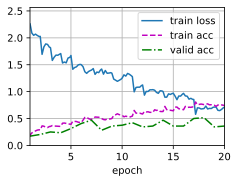

In [13]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

**对测试集进行分类并提交结果**

train loss 0.613,train acc 0.771
965.0 examples/sec on [device(type='cuda', index=0)]


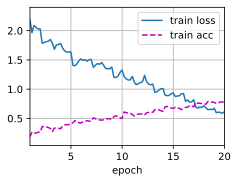

In [14]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)
for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1,len(test_ds)+1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id':sorted_ids,'label':preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
# df.to_csv('submission.csv',index=False)